In [89]:
%load_ext autoreload
%autoreload 2

from nocap.models import clip_model_dict, model_config
from nocap.api import ImageCaptionerAPI
from nocap.utils import get_device, get_wandb_checkpoint_path
import torch
from nocap.dataset import Flickr30k
import matplotlib.pyplot as plt
import numpy as np

model_config['show_attention'] = True

captioner = ImageCaptionerAPI(clip_model_dict, 
                model_config, 
                'kwokkenton-individual/mlx-week4-image-captioning/transformer_captioner:v31',
                device = torch.device('cpu'))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


wandb: Downloading large artifact transformer_captioner:v31, 945.22MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7


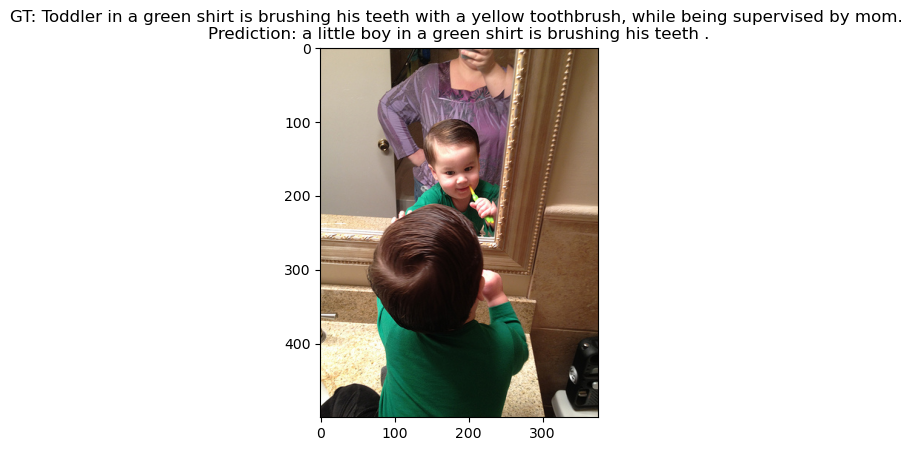

In [90]:
import random

val_ds = Flickr30k(split='val')
choice = random.randint(0, len(val_ds) -1 )
im, target = val_ds[choice]
plt.imshow(im.permute(1,2,0))
pred, attn, tokens = captioner.run_inference(im)
plt.title(f'GT: {target} \nPrediction: {pred}')
plt.show()

In [134]:
np.array(im).shape

(812, 558, 3)

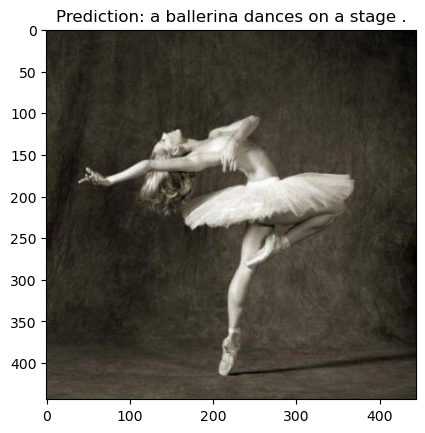

In [146]:
from PIL import Image
im = Image.open('/home/kenton/workshop/captioning/dancing.jpg')
pred, attn, tokens = captioner.run_inference(im)
plt.imshow(np.array(im))

plt.title(f'Prediction: {pred}')
plt.show()

In [ ]:
def visualize_text_to_image_attention(attn_weights, text_tokens, image_shape=(7, 7), token_idx=0):
    """
    Visualize attention from a specific text token to image patches.
    
    Parameters:
        attn_weights: Tensor (num_heads, seq_len_q, seq_len_kv)
        text_tokens: List of str — the decoded text tokens (length 13 in your example)
        image_shape: Tuple — spatial shape of image patch grid (e.g., (7, 7))
        head: int — attention head index
        token_idx: int — index of the text token (0 to 12)

    """
    assert attn_weights.shape[1] == attn_weights.shape[2], "Expected square attention matrix"
    # assert attn_weights.shape[1] >= len(text_tokens) + np.prod(image_shape), "Invalid token sizes"

    num_heads = attn_weights.shape[0]
    num_img = np.prod(image_shape)
    text_start = num_img

    # Extract attention for a single head and text token
    # First token is the CLS token
    attn = attn_weights[:, text_start + token_idx, 1:num_img+1].mean(axis=0)  # shape (50,)
    attn = attn.detach().cpu().numpy()
    attn = attn.reshape(image_shape)
    return attn

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68855715..1.3851995].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68855715..1.3851995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68855715..1.3851995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68855715..1.3851995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68855715..1.3851995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68855715..1.3851995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.68855715..1.3851995].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.

['iVBORw0KGgoAAAANSUhEUgAAAoAAAAHgCAYAAAA10dzkAAEAAElEQVR4nOz9acwuy1kdDK+qnu7xmfa8zz62j48dYxyGhCh+GW0DQYqBAIEoYQgQWQFFURAJyY+EIOxEmEjwA14LBSLCEAwCGSWMEV8gxogkVkQSOSRk5MXGGA/n7OGZ7qG7q+r6flR1d3V19T08097bu9bRPk93zV3dd9fqdVVdxYiIEBAQEBAQEBAQ8MyAP+4GBAQEBAQEBAQEXC0CAQwICAgICAgIeMYQCGBAQEBAQEBAwDOGQAADAgICAgICAp4xBAIYEBAQEBAQEPCMIRDAgICAgICAgIBnDIEABgQEBAQEBAQ8YwgEMCAgICAgICDgGUMggAEBAQEBAQEBzxgCAQwICAgICAgIeMYQCGBAQEBAQEBAwDOGQAADAgICAgICAp4xBAIYEBAQEBAQEPCMIRDAgICAgICAgIBnDIEABgQEBAQEBAQ8YwgEMCAgICAgICDgGUMggAEBAQEBAQEBzxgCAQwICAgICAgIeMYQCGBAQEBAQEBAwDOGQAADAgICAgICAp4xBAIYEBAQEBAQEPCMIRDAgICAgICAgIBnDIEABgQEBAQEBAQ8YwgEMCAgICAgICDgGUMggAEBAQEBAQEBzxgCAQwICAgICAgIeMYQCGBAQEBAQEBAwDOGQAADAgICAgICAp4xBAIYEBAQEBAQEPCMIRDAgICAgICAgIBnDIEABgQEBAQEBAQ8YwgEMCAgICAgICDgGUMggAEBAQEBAQEBzxgCAQwICAgICAgIeMYQCGBAQEBAQEBAwDOGQAADAgICAgICAp4xBAIYEBBwaXjVq16Ft7/97Vvlmc/nePvb3473ve99l9Km//E//gfe/va340Mf+tC5ynnXu96F17zmNUjTFIwxHB4e4p3vfCd+4Rd+4ULauQr/4T/8B7z97W/H4eFhJ+5973sfGGPnvr6AgIBPbgQCGBAQ8ERhPp/jHe

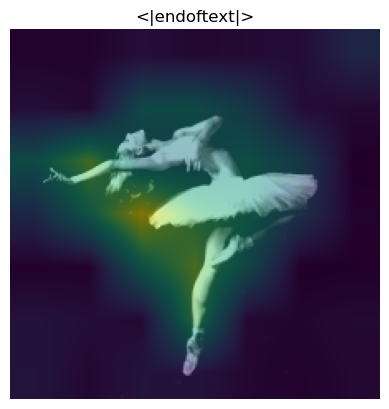

In [155]:
import torch.nn.functional as F
import torch

from io import BytesIO
import base64

def get_attention_maps(tokens, layer = 1):
    N_tokens = len(tokens)
    encoded_images = []

    for token_idx in range(N_tokens):
        attn_mat = visualize_text_to_image_attention(attn[layer][0], tokens, token_idx=token_idx)

        # Convert to tensor and unsqueeze to shape [1, 1, H, W] for interpolation
        attn_tensor = torch.tensor(attn_mat).unsqueeze(0).unsqueeze(0)  # [1, 1, 7, 7]
        # Resize to match the image shape (e.g., 224x224)
        attn_resized = F.interpolate(attn_tensor, size=(224,224), mode='bilinear', align_corners=False)
        attn_resized = attn_resized.squeeze().numpy()  # Shape: (224, 224)


        mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])
        std = torch.tensor([0.26862954, 0.26130258, 0.27577711])
        plt.title(f'{tokens[token_idx]}')
        plt.imshow(2*(captioner.model.image_processor(images= [im], return_tensors='pt')['pixel_values'][0].permute(1,2,0) + mean) * std  )
        plt.imshow(attn_resized, alpha=0.5)
        plt.axis('off')

        buf = BytesIO()
        plt.savefig(buf, format='PNG')
        buf.seek(0)
        img = Image.open(buf)

        # Convert the image to base64 for sending it in the response
        img_byte_arr = BytesIO()
        img.save(img_byte_arr, format='PNG')
        encoded_img = base64.b64encode(img_byte_arr.getvalue()).decode('utf-8')
        encoded_images.append(encoded_img)

    return encoded_images

get_attention_maps(tokens)

In [93]:
captioner.model

ImageCaptioner(
  (vision_model): CLIPVisionModel(
    (vision_model): CLIPVisionTransformer(
      (embeddings): CLIPVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
        (position_embedding): Embedding(50, 768)
      )
      (pre_layrnorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
       

In [94]:
captioner.run_inference(im)

('a little boy in a green shirt is brushing his teeth .',
 [tensor([[[[1.4821e-12, 1.8088e-03, 5.7466e-03,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [1.0000e+00, 4.7293e-17, 7.8757e-18,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [1.0000e+00, 1.8147e-14, 4.6892e-15,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            ...,
            [5.5022e-02, 3.2257e-04, 2.4536e-04,  ..., 8.6187e-02,
             0.0000e+00, 0.0000e+00],
            [3.7067e-02, 1.1691e-05, 7.8783e-06,  ..., 8.1438e-02,
             8.5746e-02, 0.0000e+00],
            [3.3433e-02, 5.7886e-06, 3.7843e-06,  ..., 7.5834e-02,
             8.0190e-02, 7.0936e-02]],
  
           [[1.6683e-11, 4.1579e-03, 9.9752e-05,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [1.0000e+00, 1.0141e-09, 5.9573e-08,  ..., 0.0000e+00,
             0.0000e+00, 0.0000e+00],
            [1.0000e+00, 1.6886e-09, 8.9986e-08,  ..., 0.0000e+00,
             0